# Pittsburgh datas by Neighborhood 🚗
Computing commutability scores per Pittsburgh neighborhood.

## 🔢 Data

In [1]:
import pandas as pd

# read census data
data = pd.read_csv("data/SNAP/Neighborhoods_with_SNAP_data.csv")

# make easier column names
data['name'] = data['Neighborhood_2010_HOOD']             # neighborhood name
data['drive'] = data['SNAP_All_csv_Commute_to_Work__D']   # drive to work alone
data['carpool'] = data['SNAP_All_csv_Commute_to_Work__C'] # carpool/vanpool
data['public'] = data['SNAP_All_csv_Commute_to_Work__P']  # public transit
data['taxi'] = data['SNAP_All_csv_Commute_to_Work__T']    # taxi
data['motor'] = data['SNAP_All_csv_Commute_to_Work__M']   # motorcycle
data['bike'] = data['SNAP_All_csv_Commute_to_Work__B']    # bike
data['walk'] = data['SNAP_All_csv_Commute_to_Work__W']    # walk
data['other'] = data['SNAP_All_csv_Commute_to_Work__O']   # other

# clean data
data = data.fillna(0)

## 📊 Metrics

In [11]:
# constants to determine value of method
# best values are 1, okay are 0.5, bad or null are 0.25
good = 1   # bike, walk
okay = 0.5 # carpool, public transit
bad = 0.25 # drive, taxi, motorcycle, other

# convert percent value to float
def convert(value):
    value = str(value)
    value = value.replace('%','')
    return float(value)

# iterate through rows, calculate commutability score
for idx, row in data.iterrows():
    score = convert(data.loc[idx,'bike']) + convert(data.loc[idx, 'walk']) # good methods
    score += okay*(convert(data.loc[idx, 'carpool']) + convert(data.loc[idx, 'public'])) # okay methods
    score += bad*(convert(data.loc[idx, 'drive']) + convert(data.loc[idx, 'taxi']) + convert(data.loc[idx, 'motor']) + convert(data.loc[idx, 'other'])) # bad methods
    data.at[idx,'raw'] = score # set neighborhood's commutability score

# find score using Pawel's formula
data['score'] = data['raw']/data['raw'].max()

# create results dataframe
commute = data[['name','score']] # create dataframe
commute = commute.sort_values(by=['name']).set_index('name') # sort and set name index
commute # print table

,score
name,
Allegheny Center,0.836108
Allegheny West,0.698008
Allentown,0.480248
Arlington,0.405158
Arlington Heights,0.616716
...,...
Upper Lawrenceville,0.464577
West End,0.433562
West Oakland,0.801828


## 🗺 Visualization

<AxesSubplot:>

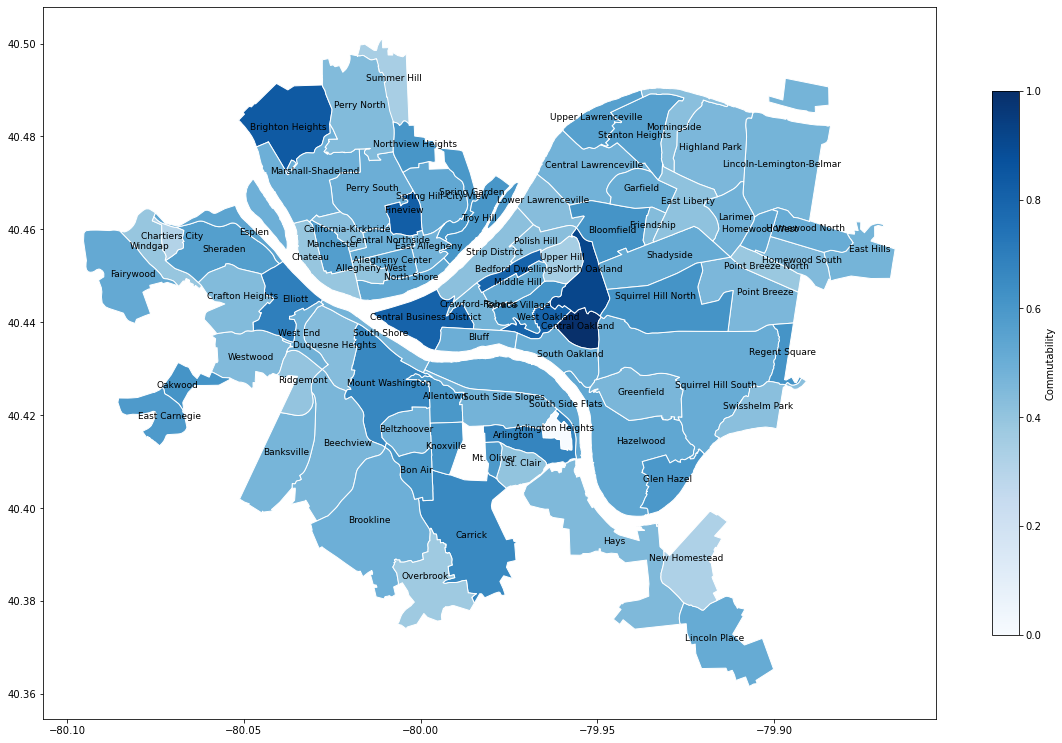

In [7]:
import geopandas as gpd
%matplotlib inline
from matplotlib import pyplot as plt

# read in map data
pgh = gpd.read_file("data/Neighborhoods/Neighborhoods_.shp")

# project map data to lat/lon
pgh['geometry'] = pgh['geometry'].to_crs(epsg=4326)

# add neighborhood labels to map
def label_map():
    pgh['coords'] = pgh['geometry'].apply(lambda x: x.representative_point().coords[:])
    pgh['coords'] = [coords[0] for coords in pgh['coords']]
    for idx, row in pgh.iterrows():
        plt.annotate(text = row['hood'], xy=row['coords'],
                     horizontalalignment='center', size=9)

# add scores to map
pgh['score'] = commute['score']

# plot map
fig,ax = plt.subplots(figsize = (20,20)) # plot size
label_map()
pgh.plot(ax=ax, column='score', cmap='Blues', edgecolor="white", legend='True', legend_kwds={'label': "Commutability", 'shrink': 0.5})